In [1]:
from datasets import load_dataset

ds = load_dataset("allenai/WildChat-4.8M")


c:\Microsoft VS Code\VsCodeProject\Prof.Yu\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset  
print(ds["train"].features) 
print(ds["train"].column_names)

{'conversation_hash': Value('string'), 'model': Value('string'), 'timestamp': Value('timestamp[us]'), 'conversation': List({'content': Value('string'), 'created': Value('int64'), 'header': {'accept-language': Value('string'), 'user-agent': Value('string')}, 'hashed_ip': Value('string'), 'country': Value('string'), 'toxic': Value('bool'), 'redacted': Value('bool'), 'state': Value('string'), 'language': Value('string'), 'openai_id': Value('string'), 'role': Value('string'), 'temperature': Value('float64'), 'timestamp': Value('timestamp[us]'), 'token_counter': Value('int64'), 'top_p': Value('float64'), 'turn_identifier': Value('int64'), 'system_fingerprint': Value('string'), 'usage': {'completion_tokens': Value('int64'), 'completion_tokens_details': {'reasoning_tokens': Value('int64'), 'text_tokens': Value('int64'), 'audio_tokens': Value('int64'), 'accepted_prediction_tokens': Value('int64'), 'rejected_prediction_tokens': Value('int64')}, 'prompt_tokens': Value('int64'), 'total_tokens': V

## 1. only "english" and filter out those data without content including "literature review"

In [3]:
from datasets import load_dataset

train = ds["train"]

def is_english(example):
    lang = example.get("language") or ""
    return isinstance(lang, str) and lang.lower() == "english"

def contains_lit_review(example):
    conv = example.get("conversation") or example.get("conversations") or []
    if isinstance(conv, dict):
        content = conv.get("content") or conv.get("text") or ""
        return isinstance(content, str) and "literature review" in content.lower()
    for msg in conv:
        if isinstance(msg, str):
            if "literature review" in msg.lower():
                return True
        if isinstance(msg, dict):
            content = msg.get("content")
            if isinstance(content, str) and "literature review" in content.lower():
                return True
    return False

english_ds = train.filter(is_english)

result_ds = english_ds.filter(contains_lit_review)

print("matches:", result_ds.num_rows)
print(result_ds[:5]) 

matches: 2828
{'conversation_hash': ['f119a9facac0b73768ba222235191e8c', '244ca4d4c25048eab5ffd2143674c962', '97c0cfb2b2c0927430663d94cc224671', '6bf9bc2150bf25b1454bc908b7d0656c', 'f1efddaa90a0acf0674ce2ce0a9a9d8f'], 'model': ['gpt-4-0314', 'gpt-4-0314', 'gpt-4-0314', 'gpt-4-0314', 'gpt-4-0314'], 'timestamp': [datetime.datetime(2023, 4, 9, 1, 42, 3), datetime.datetime(2023, 4, 9, 3, 40, 40), datetime.datetime(2023, 4, 9, 3, 58, 26), datetime.datetime(2023, 4, 9, 5, 38, 2), datetime.datetime(2023, 4, 9, 5, 42, 3)], 'conversation': [[{'content': 'I would liketo be a researcher of artificial intelligence (architecture) and an architectural teacher, requiringyou tostudya given topic, develop thesisstatements,and createconvincing documentsthatareboth informative and innovative, while offering assistance toarchitectsandarchitectswhoneedto improve their writing, and you will beresponsible for providing feedback to architects and architectsusingartificial intelligence toolssuch as natural lan

In [4]:
print(ds)                       
print(ds["train"].features)     
print(ds["train"].column_names) 

sample = ds["train"][0]
print(type(sample.get("conversation")), sample.get("conversation"))

DatasetDict({
    train: Dataset({
        features: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header'],
        num_rows: 3199860
    })
})
{'conversation_hash': Value('string'), 'model': Value('string'), 'timestamp': Value('timestamp[us]'), 'conversation': List({'content': Value('string'), 'created': Value('int64'), 'header': {'accept-language': Value('string'), 'user-agent': Value('string')}, 'hashed_ip': Value('string'), 'country': Value('string'), 'toxic': Value('bool'), 'redacted': Value('bool'), 'state': Value('string'), 'language': Value('string'), 'openai_id': Value('string'), 'role': Value('string'), 'temperature': Value('float64'), 'timestamp': Value('timestamp[us]'), 'token_counter': Value('int64'), 'top_p': Value('float64'), 'turn_identifier': Value('int64'), 'system_fingerprint': Value('string'), 'usage': {'completion_tokens': Value('int

columns: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header']


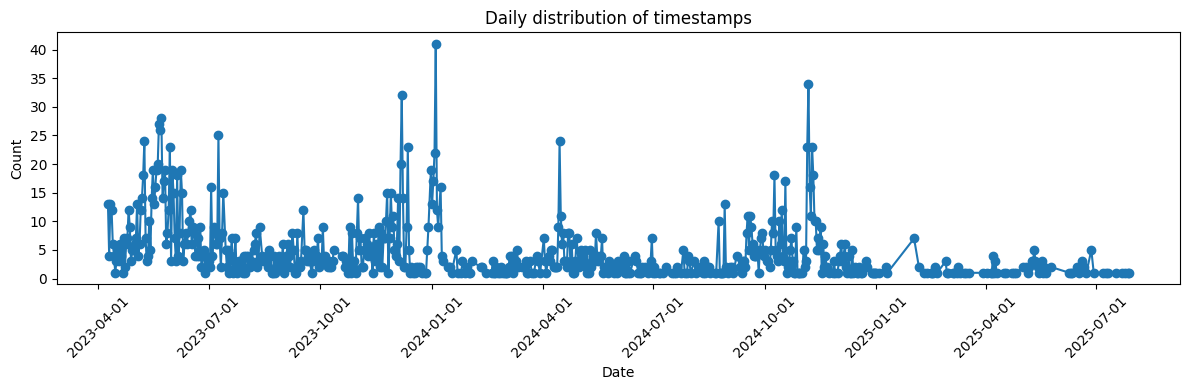

In [5]:
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

try:
    from dateutil import parser as _dateutil_parser
except Exception:
    _dateutil_parser = None

ts_col = "timestamp"   
batch_size = 10000     # 根据内存和数据量调整

def as_datetime(v):
    if v is None:
        return None
    if isinstance(v, datetime):
        return v
    if isinstance(v, (int, float)):
        return datetime.fromtimestamp(v/1000.0) if abs(v) > 1e11 else datetime.fromtimestamp(v)
    if isinstance(v, str):
        try:
            return datetime.fromisoformat(v)
        except Exception:
            if _dateutil_parser:
                try:
                    return _dateutil_parser.parse(v)
                except Exception:
                    return None
            return None
    return None

# 检查列存在
print("columns:", result_ds.column_names)
assert ts_col in result_ds.column_names, f"找不到列 {ts_col}"

counter = Counter()
n = len(result_ds)
for start in range(0, n, batch_size):
    end = min(n, start + batch_size)
    batch = result_ds[start:end]
    vals = batch[ts_col]
    for v in vals:
        if isinstance(v, (list, tuple)):
            for sub in v:
                dt = as_datetime(sub)
                if dt:
                    counter[dt.date()] += 1
        else:
            dt = as_datetime(v)
            if dt:
                counter[dt.date()] += 1

if not counter:
    raise RuntimeError("未解析到有效时间，请检查时间列格式或列名")

dates_sorted = sorted(counter.keys())
counts = [counter[d] for d in dates_sorted]

plt.figure(figsize=(12,4))
plt.plot(dates_sorted, counts, marker='o', linestyle='-')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily distribution of timestamps')
plt.tight_layout()
plt.show()

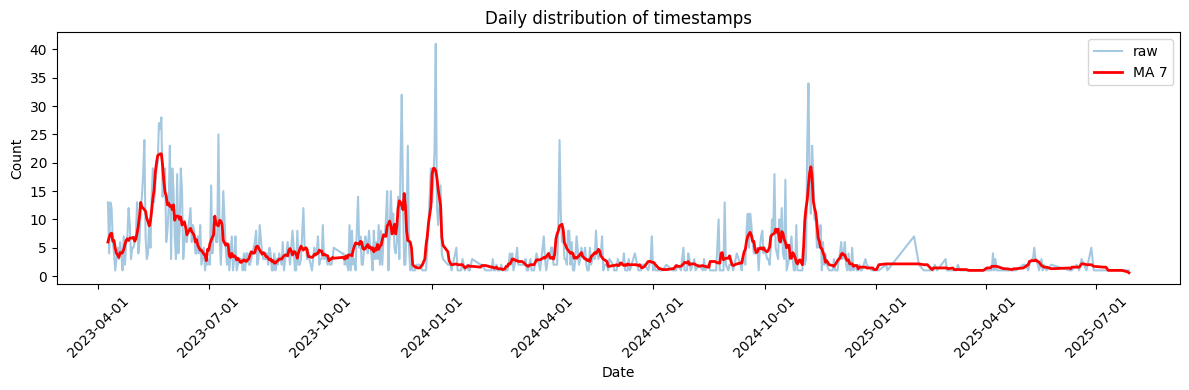

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Simple moving average
def moving_average(y, window):
    kernel = np.ones(window) / window
    return np.convolve(y, kernel, mode="same")

window = 7   # 7 / 14 / 30
smoothed = moving_average(counts, window)

plt.figure(figsize=(12,4))
plt.plot(dates_sorted, counts, alpha=0.4, label="raw")
plt.plot(dates_sorted, smoothed, color="red", linewidth=2, label=f"MA {window}")
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45); plt.legend()
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily distribution of timestamps')
plt.tight_layout()
plt.show()

In [ ]:
sample = result_ds[0]
print(type(sample.get("model")), sample.get("model"))
print(result_ds.unique("model"))
print(type(sample.get("turn")), sample.get("turn"))

<class 'str'> gpt-4-0314


Flattening the indices: 100%|██████████| 2828/2828 [00:07<00:00, 375.73 examples/s]

['gpt-4-0314', 'gpt-3.5-turbo-0301', 'gpt-3.5-turbo-0613', 'gpt-4-1106-preview', 'gpt-3.5-turbo-0125', 'gpt-4-0125-preview', 'gpt-4-turbo-2024-04-09', 'gpt-4o-2024-05-13', 'gpt-4o-mini-2024-07-18', 'gpt-4o-2024-08-06', 'o1-preview-2024-09-12', 'o1-mini-2024-09-12', 'gpt-4o-2024-11-20', 'gpt-4.1-mini-2025-04-14']


counts: {'gpt-4': 809, 'gpt-3.5-turbo': 1229, 'gpt-4o': 504, 'o1': 222, 'gpt-4.1-mini': 64}


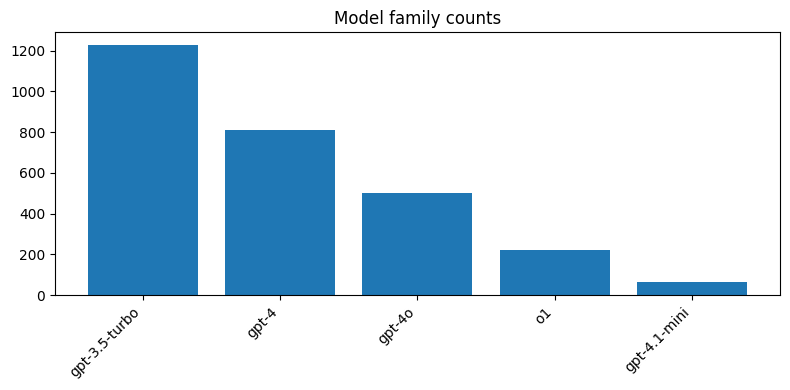

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

def model_family(name):
    if not name: 
        return "other"
    n = name.lower()
    if n.startswith("gpt-4o"):
        return "gpt-4o"
    if n.startswith("gpt-3.5"):
        return "gpt-3.5-turbo"
    if n.startswith("gpt-4.1"):
        return "gpt-4.1-mini"
    if n.startswith("gpt-4"):
        return "gpt-4"
    if n.startswith("o1"):
        return "o1"
    return "other"

cnt = Counter()
batch_size = 10000
n = len(result_ds)
for start in range(0, n, batch_size):
    vals = result_ds[start:start+batch_size]["model"]   
    cnt.update(model_family(v) for v in vals)

print("counts:", dict(cnt))

labels, values = zip(*cnt.most_common())
plt.figure(figsize=(8,4))
plt.bar(labels, values, color="C0")
plt.xticks(rotation=45, ha="right")
plt.title("Model family counts")
plt.tight_layout()
plt.show()


## For all data compare

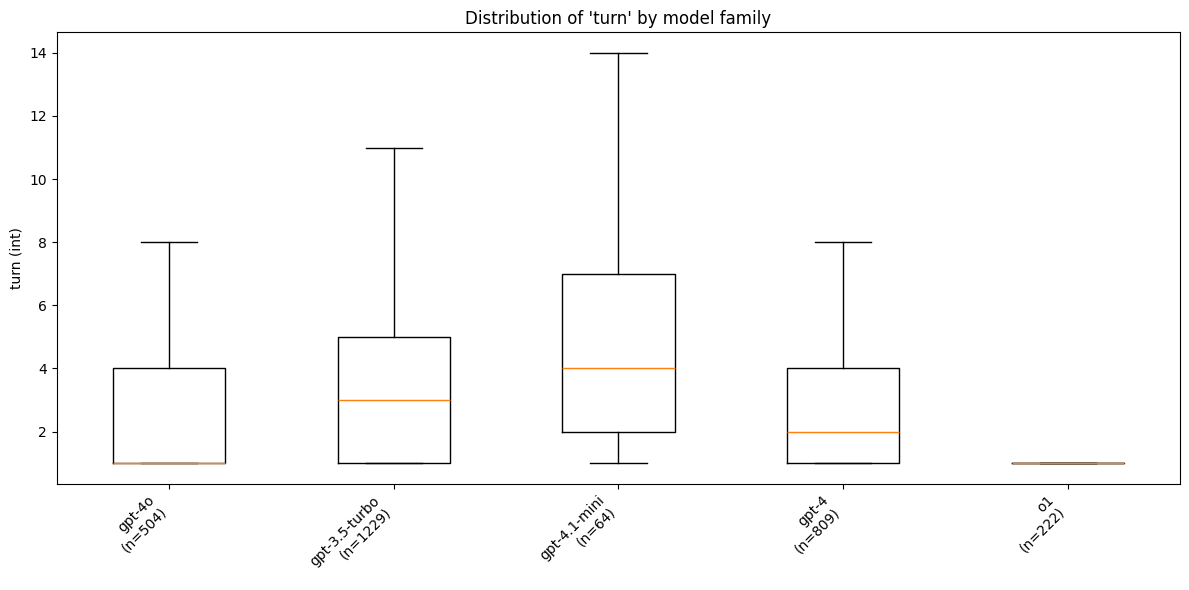

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

def model_family5(name):
    if not name:
        return None
    n = name.lower()
    if n.startswith("gpt-4o"):
        return "gpt-4o"
    if n.startswith("gpt-3.5"):
        return "gpt-3.5-turbo"
    if n.startswith("gpt-4.1"):
        return "gpt-4.1-mini"
    if n.startswith("gpt-4"):
        return "gpt-4"
    if n.startswith("o1"):
        return "o1"
    return None

models = result_ds["model"]
turns  = result_ds["turn"]

samples = defaultdict(list)
for m, t in zip(models, turns):
    fam = model_family5(m)
    if fam is None:
        continue
    try:
        val = int(t)
    except Exception:
        continue
    samples[fam].append(val)

order = ["gpt-4o", "gpt-3.5-turbo", "gpt-4.1-mini", "gpt-4", "o1"]
data = []
labels = []
for fam in order:
    lst = samples.get(fam, [])
    if not lst:
        continue
    data.append(lst)
    labels.append(f"{fam}\n(n={len(lst)})")

if not data:
    raise RuntimeError("Fail to collect turn data")

plt.figure(figsize=(12,6))
plt.boxplot(data, tick_labels=labels, showfliers=False)
plt.ylabel("turn (int)")
plt.title("Distribution of 'turn' by model family")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

family	count	median	IQR	10th	90th	mean
gpt-4o	504	1.00	3.00	1.00	10.00	4.60
gpt-3.5-turbo	1229	3.00	4.00	1.00	8.00	3.88
gpt-4.1-mini	64	4.00	5.00	1.00	15.40	6.41
gpt-4	809	2.00	3.00	1.00	9.00	4.19
o1	222	1.00	0.00	1.00	1.00	1.00


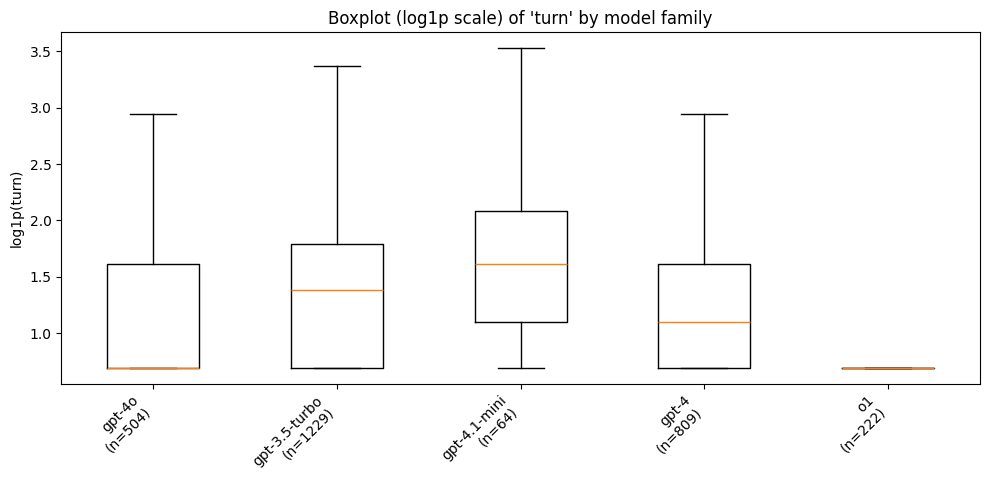

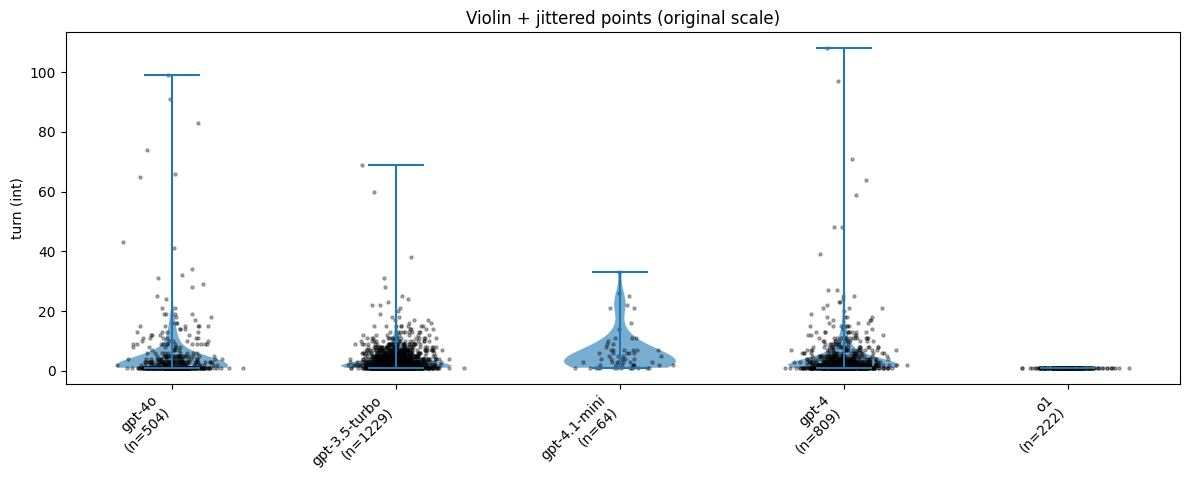

In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import random

def model_family5(name):
    if not name:
        return None
    n = name.lower()
    if n.startswith("gpt-4o"):
        return "gpt-4o"
    if n.startswith("gpt-3.5"):
        return "gpt-3.5-turbo"
    if n.startswith("gpt-4.1"):
        return "gpt-4.1-mini"
    if n.startswith("gpt-4"):
        return "gpt-4"
    if n.startswith("o1"):
        return "o1"
    return None

models = result_ds["model"]
turns  = result_ds["turn"]
samples = defaultdict(list)
for m, t in zip(models, turns):
    fam = model_family5(m)
    if fam is None:
        continue
    try:
        val = int(t)
    except Exception:
        continue
    samples[fam].append(val)

order = ["gpt-4o", "gpt-3.5-turbo", "gpt-4.1-mini", "gpt-4", "o1"]

# compute and print robust stats
print("family\tcount\tmedian\tIQR\t10th\t90th\tmean")
for fam in order:
    lst = np.array(samples.get(fam, []))
    if lst.size == 0:
        continue
    med = np.median(lst)
    q1, q3 = np.percentile(lst, [25, 75])
    iqr = q3 - q1
    p10, p90 = np.percentile(lst, [10, 90])
    mean = np.mean(lst)
    print(f"{fam}\t{len(lst)}\t{med:.2f}\t{iqr:.2f}\t{p10:.2f}\t{p90:.2f}\t{mean:.2f}")

# 1) boxplot on log1p scale (recommended for skewed counts)
data_log = [np.log1p(samples[f]) for f in order if samples.get(f)]
labels = [f"{f}\n(n={len(samples[f])})" for f in order if samples.get(f)]

plt.figure(figsize=(10,5))
try:
    plt.boxplot(data_log, tick_labels=labels, showfliers=False)
except TypeError:
    plt.boxplot(data_log, labels=labels, showfliers=False)
plt.ylabel("log1p(turn)")
plt.title("Boxplot (log1p scale) of 'turn' by model family")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 2) violin + jittered scatter on original scale (shows raw spread)
data = [samples[f] for f in order if samples.get(f)]
pos = np.arange(1, len(data) + 1)

plt.figure(figsize=(12,5))
# violin (matplotlib)
parts = plt.violinplot(data, positions=pos, showmeans=False, showextrema=True)
for pc in parts['bodies']:
    pc.set_alpha(0.6)
# jittered scatter
for i, lst in enumerate(data, start=1):
    y = np.array(lst)
    x = np.random.normal(i, 0.08, size=y.size)  # small jitter
    plt.scatter(x, y, s=5, alpha=0.3, color='k')

plt.xticks(pos, labels, rotation=45, ha="right")
plt.ylabel("turn (int)")
plt.title("Violin + jittered points (original scale)")
plt.tight_layout()
plt.show()

removed (per family) when cutoff=40: {'gpt-4o': 8, 'gpt-3.5-turbo': 2, 'gpt-4.1-mini': 0, 'gpt-4': 7, 'o1': 0}


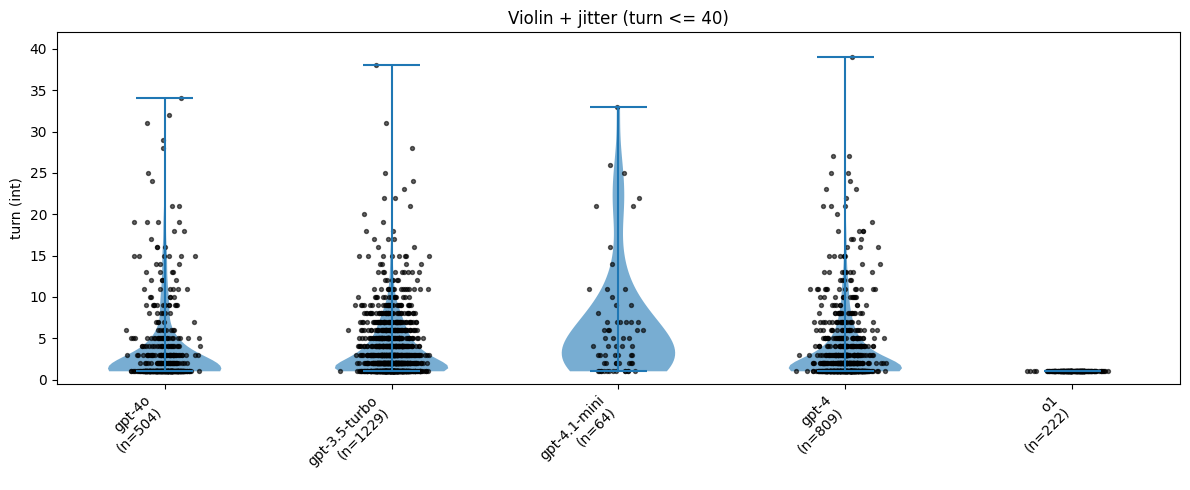

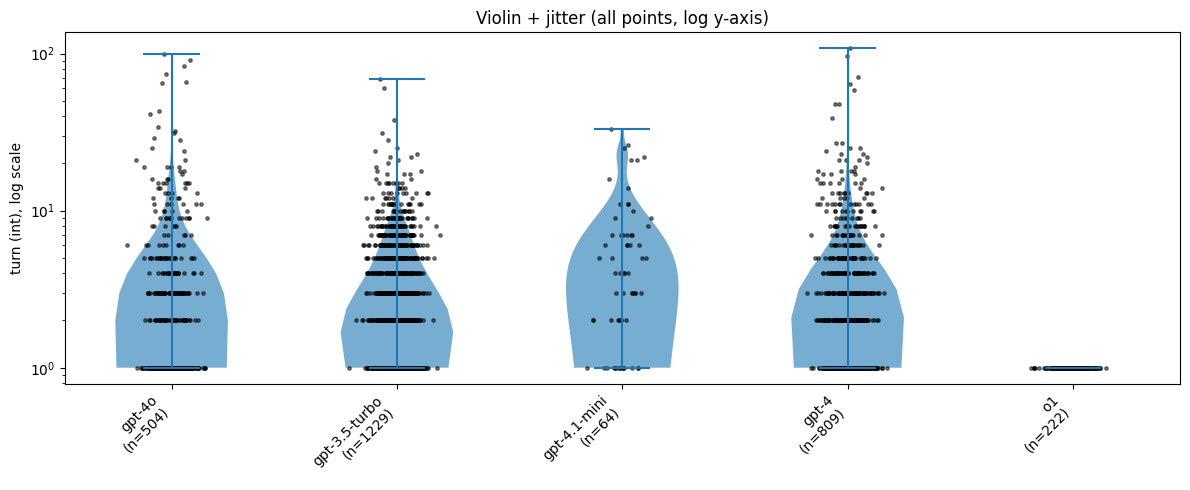

In [ ]:
# A: ignore turn > cutoff
cutoff = 40
filtered = {f: [v for v in samples.get(f, []) if v <= cutoff] for f in order}
removed_counts = {f: len(samples.get(f, [])) - len(filtered[f]) for f in order}
print("removed (per family) when cutoff=%d:" % cutoff, removed_counts)

data = [filtered[f] for f in order if filtered.get(f)]
labels = [f"{f}\n(n={len(samples.get(f,[]))})" for f in order if filtered.get(f)]

plt.figure(figsize=(12,5))
parts = plt.violinplot(data, positions=np.arange(1, len(data)+1), showmeans=False, showextrema=True)
for pc in parts['bodies']:
    pc.set_alpha(0.6)
# jitter points
for i, lst in enumerate(data, start=1):
    y = np.array(lst)
    if y.size == 0:
        continue
    x = np.random.normal(i, 0.06, size=y.size)
    plt.scatter(x, y, s=8, alpha=0.6, color='k')
plt.xticks(np.arange(1, len(data)+1), labels, rotation=45, ha='right')
plt.ylabel("turn (int)")
plt.title(f"Violin + jitter (turn <= {cutoff})")
plt.ylim(-0.5, cutoff + 2)
plt.tight_layout()
plt.show()

# B: log scale
data_all = [samples[f] for f in order if samples.get(f)]
labels_all = [f"{f}\n(n={len(samples.get(f,[]))})" for f in order if samples.get(f)]

plt.figure(figsize=(12,5))
parts = plt.violinplot(data_all, positions=np.arange(1, len(data_all)+1), showmeans=False, showextrema=True)
for pc in parts['bodies']:
    pc.set_alpha(0.6)
for i, lst in enumerate(data_all, start=1):
    y = np.array(lst)
    if y.size == 0:
        continue
    x = np.random.normal(i, 0.06, size=y.size)
    plt.scatter(x, y, s=6, alpha=0.5, color='k')
plt.xticks(np.arange(1, len(data_all)+1), labels_all, rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("turn (int), log scale")
plt.title("Violin + jitter (all points, log y-axis)")
plt.tight_layout()
plt.show()

## Analysis With Characterist numbers

In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

def extract_contents(conv):
    if conv is None:
        return []
    if isinstance(conv, (list, tuple)):
        texts = []
        for msg in conv:
            if isinstance(msg, str):
                texts.append(msg)
            elif isinstance(msg, dict):
                c = msg.get("content") or msg.get("text")
                if isinstance(c, str):
                    texts.append(c)
        return texts
    return []

def count_words_from_text(s):
    if not s:
        return 0
    return len(s.split())

models = result_ds["model"]
turns  = result_ds["turn"]
convs  = result_ds["conversation"]

avg_words_per_turn = []
skipped = 0
for m, t, conv in zip(models, turns, convs):
    try:
        turn_val = int(t)
    except Exception:
        skipped += 1
        continue
    if turn_val <= 0:
        skipped += 1
        continue
    texts = extract_contents(conv)
    total_words = sum(count_words_from_text(x) for x in texts)
    avg = total_words / turn_val
    avg_words_per_turn.append(avg)

avg_arr = np.array(avg_words_per_turn)
print(f"kept samples: {avg_arr.size}, skipped (bad turn/zero): {skipped}")

if avg_arr.size:
    med = np.median(avg_arr)
    q1, q3 = np.percentile(avg_arr, [25,75])
    iqr = q3 - q1
    p10, p90 = np.percentile(avg_arr, [10,90])
    mean = np.mean(avg_arr)
    print("metric\tcount\tmedian\tIQR\t10th\t90th\tmean")
    print(f"avg_words_per_turn\t{avg_arr.size}\t{med:.2f}\t{iqr:.2f}\t{p10:.2f}\t{p90:.2f}\t{mean:.2f}")
else:
    raise RuntimeError("no valid avg_words_per_turn data")

kept samples: 2828, skipped (bad turn/zero): 0
metric	count	median	IQR	10th	90th	mean
avg_words_per_turn	2828	646.83	1178.00	239.07	4326.95	1748.37


In [ ]:
# plot 1: histplot
plt.figure(figsize=(8,4))
plt.hist(avg_arr, bins=40, color="C0", alpha=0.8)
plt.xlabel("avg words per turn")
plt.ylabel("count")
plt.title("Histogram of avg words per turn")
plt.tight_layout()
plt.show()

# plot 2: boxplot（log1p）
# plt.figure(figsize=(6,4))
# try:
#     plt.boxplot([np.log1p(avg_arr)], tick_labels=["log1p(avg words/turn)"], showfliers=False)
# except TypeError:
#     plt.boxplot([np.log1p(avg_arr)], labels=["log1p(avg words/turn)"], showfliers=False)
# plt.title("Boxplot (log1p) of avg words per turn")
# plt.tight_layout()
# plt.show()

# plot 3: violin + jitter 
# cutoff = 5000.0  
# vis_vals = avg_arr[avg_arr <= cutoff]
# print(f"visualizing {vis_vals.size} points (<= {cutoff}), removed {avg_arr.size - vis_vals.size}")
# plt.figure(figsize=(8,4))
# parts = plt.violinplot([vis_vals], showmeans=False, showextrema=True)
# for pc in parts.get('bodies', []):
#     pc.set_alpha(0.6)
# # jitter points
# x = np.random.normal(1, 0.04, size=vis_vals.size)
# plt.scatter(x, vis_vals, s=8, alpha=0.6, color='k')
# plt.xticks([1], [f"avg words/turn\n(n={vis_vals.size})"])
# plt.ylabel("avg words per turn")
# plt.title(f"Violin + jitter (values <= {cutoff})")
# plt.ylim(-0.5, cutoff + 1)
# plt.tight_layout()
# plt.show()


family	count	median	IQR	10th	90th	mean
gpt-4o	504	1663.50	2871.25	344.30	7010.00	2699.16
gpt-3.5-turbo	1229	406.00	303.00	174.80	978.40	555.27
gpt-4.1-mini	64	820.00	903.00	299.90	2848.30	1521.39
gpt-4	809	924.00	1517.00	420.80	5107.20	2223.71
o1	222	2370.00	6194.00	728.10	10802.70	4525.48


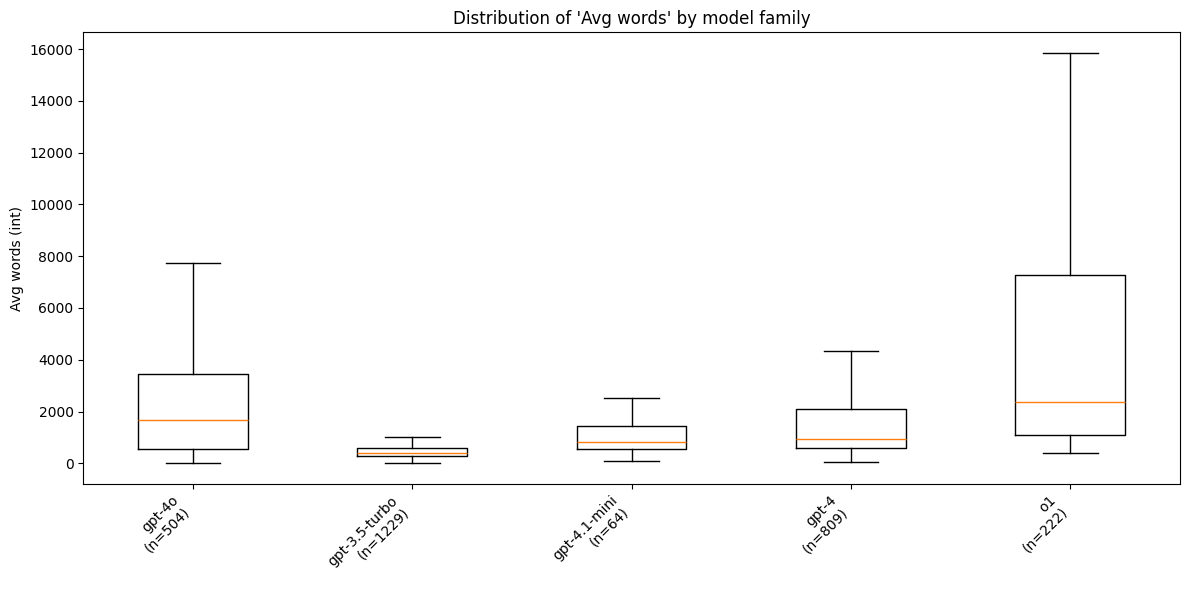

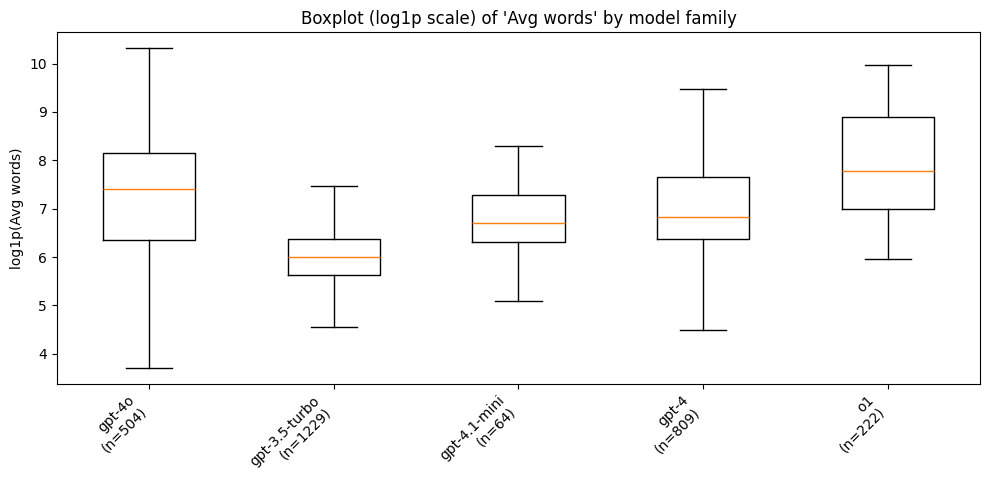

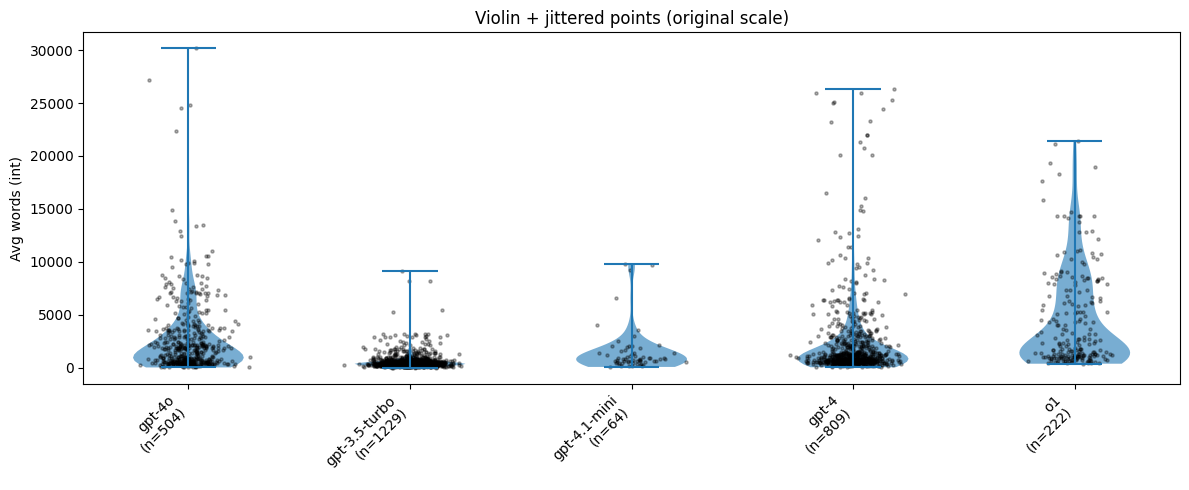

In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import random

def model_family5(name):
    if not name:
        return None
    n = name.lower()
    if n.startswith("gpt-4o"):
        return "gpt-4o"
    if n.startswith("gpt-3.5"):
        return "gpt-3.5-turbo"
    if n.startswith("gpt-4.1"):
        return "gpt-4.1-mini"
    if n.startswith("gpt-4"):
        return "gpt-4"
    if n.startswith("o1"):
        return "o1"
    return None



models = result_ds["model"]
turns  = avg_arr
samples = defaultdict(list)
for m, t in zip(models, turns):
    fam = model_family5(m)
    if fam is None:
        continue
    try:
        val = int(t)
    except Exception:
        continue
    samples[fam].append(val)

order = ["gpt-4o", "gpt-3.5-turbo", "gpt-4.1-mini", "gpt-4", "o1"]

# compute and print robust stats
print("family\tcount\tmedian\tIQR\t10th\t90th\tmean")
for fam in order:
    lst = np.array(samples.get(fam, []))
    if lst.size == 0:
        continue
    med = np.median(lst)
    q1, q3 = np.percentile(lst, [25, 75])
    iqr = q3 - q1
    p10, p90 = np.percentile(lst, [10, 90])
    mean = np.mean(lst)
    print(f"{fam}\t{len(lst)}\t{med:.2f}\t{iqr:.2f}\t{p10:.2f}\t{p90:.2f}\t{mean:.2f}")

# Basic Boxplot
data = []
labels = []
for fam in order:
    lst = samples.get(fam, [])
    if not lst:
        continue
    data.append(lst)
    labels.append(f"{fam}\n(n={len(lst)})")

if not data:
    raise RuntimeError("Fail to collect turn data")

plt.figure(figsize=(12,6))
plt.boxplot(data, tick_labels=labels, showfliers=False)
plt.ylabel("Avg words (int)")
plt.title("Distribution of 'Avg words' by model family")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# 1) boxplot on log1p scale (recommended for skewed counts)
data_log = [np.log1p(samples[f]) for f in order if samples.get(f)]
labels = [f"{f}\n(n={len(samples[f])})" for f in order if samples.get(f)]

plt.figure(figsize=(10,5))
try:
    plt.boxplot(data_log, tick_labels=labels, showfliers=False)
except TypeError:
    plt.boxplot(data_log, labels=labels, showfliers=False)
plt.ylabel("log1p(Avg words)")
plt.title("Boxplot (log1p scale) of 'Avg words' by model family")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 2) violin + jittered scatter on original scale (shows raw spread)
data = [samples[f] for f in order if samples.get(f)]
pos = np.arange(1, len(data) + 1)

plt.figure(figsize=(12,5))
# violin (matplotlib)
parts = plt.violinplot(data, positions=pos, showmeans=False, showextrema=True)
for pc in parts['bodies']:
    pc.set_alpha(0.6)
# jittered scatter
for i, lst in enumerate(data, start=1):
    y = np.array(lst)
    x = np.random.normal(i, 0.08, size=y.size)  # small jitter
    plt.scatter(x, y, s=5, alpha=0.3, color='k')

plt.xticks(pos, labels, rotation=45, ha="right")
plt.ylabel("Avg words (int)")
plt.title("Violin + jittered points (original scale)")
plt.tight_layout()
plt.show()

In [ ]:
# A: turn > cutoff
cutoff = 40
filtered = {f: [v for v in samples.get(f, []) if v <= cutoff] for f in order}
removed_counts = {f: len(samples.get(f, [])) - len(filtered[f]) for f in order}
print("removed (per family) when cutoff=%d:" % cutoff, removed_counts)

data = [filtered[f] for f in order if filtered.get(f)]
labels = [f"{f}\n(n={len(samples.get(f,[]))})" for f in order if filtered.get(f)]

plt.figure(figsize=(12,5))
parts = plt.violinplot(data, positions=np.arange(1, len(data)+1), showmeans=False, showextrema=True)
for pc in parts['bodies']:
    pc.set_alpha(0.6)
# jitter points
for i, lst in enumerate(data, start=1):
    y = np.array(lst)
    if y.size == 0:
        continue
    x = np.random.normal(i, 0.06, size=y.size)
    plt.scatter(x, y, s=8, alpha=0.6, color='k')
plt.xticks(np.arange(1, len(data)+1), labels, rotation=45, ha='right')
plt.ylabel("turn (int)")
plt.title(f"Violin + jitter (turn <= {cutoff})")
plt.ylim(-0.5, cutoff + 2)
plt.tight_layout()
plt.show()

# B: 
data_all = [samples[f] for f in order if samples.get(f)]
labels_all = [f"{f}\n(n={len(samples.get(f,[]))})" for f in order if samples.get(f)]

plt.figure(figsize=(12,5))
parts = plt.violinplot(data_all, positions=np.arange(1, len(data_all)+1), showmeans=False, showextrema=True)
for pc in parts['bodies']:
    pc.set_alpha(0.6)
for i, lst in enumerate(data_all, start=1):
    y = np.array(lst)
    if y.size == 0:
        continue
    x = np.random.normal(i, 0.06, size=y.size)
    plt.scatter(x, y, s=6, alpha=0.5, color='k')
plt.xticks(np.arange(1, len(data_all)+1), labels_all, rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("turn (int), log scale")
plt.title("Violin + jitter (all points, log y-axis)")
plt.tight_layout()
plt.show()

In [ ]:
result_ds["conversation"][0]
print(result_ds.column_names)

['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header']


In [ ]:
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

try:
    from dateutil import parser as _dateutil_parser
except Exception:
    _dateutil_parser = None

ts_col = "timestamp"   
batch_size = 10000     

def as_datetime(v):
    if v is None:
        return None
    if isinstance(v, datetime):
        return v
    if isinstance(v, (int, float)):
        return datetime.fromtimestamp(v/1000.0) if abs(v) > 1e11 else datetime.fromtimestamp(v)
    if isinstance(v, str):
        try:
            return datetime.fromisoformat(v)
        except Exception:
            if _dateutil_parser:
                try:
                    return _dateutil_parser.parse(v)
                except Exception:
                    return None
            return None
    return None


print("columns:", train.column_names)
assert ts_col in train.column_names, f"can not find {ts_col}"

counter_all = Counter()
n = len(train)
for start in range(0, n, batch_size):
    end = min(n, start + batch_size)
    batch = train[start:end]
    vals = batch[ts_col]
    for v in vals:
        if isinstance(v, (list, tuple)):
            for sub in v:
                dt = as_datetime(sub)
                if dt:
                    counter_all[dt.date()] += 1
        else:
            dt = as_datetime(v)
            if dt:
                counter_all[dt.date()] += 1

if not counter_all:
    raise RuntimeError("no valid time")

dates_sorted_all = sorted(counter_all.keys())
counts_all = [counter_all[d] for d in dates_sorted_all]

plt.figure(figsize=(12,4))
plt.plot(dates_sorted_all, counts_all, marker='o', linestyle='-')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily distribution of all timestamps')
plt.tight_layout()
plt.show()

columns: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header']


KeyboardInterrupt: 